In [42]:
import pandas as pd
df = pd.read_excel('renewable electricity generation.xlsx')
df = df.drop(["country"], axis = 1)
df

,hydro_and_marine,solar,wind,bioenergy
0,29685,1346,9412,2607
1,14764,21033,20396,3351
2,41998,2043,6792,4591
3,777,389,5,4
4,399,176,194,578
...,...,...,...,...
73,4094,462,5476,2701
74,5000,0,16,0
75,64501,8,88,0
76,73496,1660,1803,322


In [43]:
import numpy as np
import pandas as pd

def normalisasi(array_matriks):
    hasil = array_matriks / sum(array_matriks)
    return hasil


def fcm(dataframe, jumlah_cluster = 3, w = 2, maxIter = 100, error_threshold = 0.01):
    jumlah_data, jumlah_fitur = dataframe.shape

    matriks_myu = np.absolute(np.random.randn(jumlah_data, jumlah_fitur))
    v = np.zeros((jumlah_cluster, jumlah_fitur))

    df_myu = pd.read_excel("renewable_electricity_generation_model.xlsx")
    jumlah_baris_myu, jumlah_kolom_myu = df_myu.shape
    for index_baris in range(jumlah_baris_myu):
        for index_kolom in range(jumlah_kolom_myu):
            matriks_myu[index_baris][index_kolom] = df_myu.iloc[index_baris][index_kolom]

    jumlah_fungsi_objektif_sebelumnya = 0

    lebih_error = True
    iter_sekarang = 1

    while lebih_error and iter_sekarang <= maxIter:
        d_kuadrat = np.zeros((jumlah_data, jumlah_fitur))
        matriks_myu_baru = np.zeros((jumlah_data, jumlah_cluster))
        gabungan_myu_kuadrat = pow(matriks_myu, 2)

        # cari pusat cluster
        for indeks_cluster in range(jumlah_cluster):
            myu_kuadrat = []
            for indeks_data in range(jumlah_data):
                myu_kuadrat.append(
                    pow(matriks_myu[indeks_data][indeks_cluster], w))
            jumlah_myu_kuadrat = sum(myu_kuadrat)
            for indeks_fitur in range(jumlah_fitur):
                jumlah_myukuadrat_kalifitur = 0
                for indeks_data in range(jumlah_data):
                    jumlah_myukuadrat_kalifitur += myu_kuadrat[indeks_data] * \
                        dataframe.iloc[indeks_data][indeks_fitur]
                v[indeks_cluster][indeks_fitur] = jumlah_myukuadrat_kalifitur / \
                    jumlah_myu_kuadrat

        #print(v)

        # cari myu baru  
        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                for indeks_fitur in range(jumlah_fitur):
                    d_kuadrat[indeks_data][indeks_cluster] += pow(
                        dataframe.iloc[indeks_data][indeks_fitur] - v[indeks_cluster][indeks_fitur], 2)

        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                jumlah_d_kuadrat_i_bagi_d_kuadrat_j = 0
                for j in range (jumlah_cluster):
                    jumlah_d_kuadrat_i_bagi_d_kuadrat_j += pow(
                        d_kuadrat[indeks_data][indeks_cluster] / d_kuadrat[indeks_data][j], 1 / (w - 1))
                matriks_myu_baru[indeks_data][indeks_cluster] = 1 / jumlah_d_kuadrat_i_bagi_d_kuadrat_j
        
        # cari fungsi objektif
        jumlah_fungsi_objektif = 0
        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                    jumlah_fungsi_objektif += d_kuadrat[indeks_data][indeks_cluster] * gabungan_myu_kuadrat[indeks_data][indeks_cluster]
        
        #print(jumlah_fungsi_objektif)
        #print(matriks_myu_baru)
        error = abs(jumlah_fungsi_objektif - jumlah_fungsi_objektif_sebelumnya)
        print('Iterasi ke {}, Hasil Fungsi Objektif = {}, Error = {}'.format(iter_sekarang, jumlah_fungsi_objektif, error))
        
        iter_sekarang += 1
        
        lebih_error = error > error_threshold
        matriks_myu = matriks_myu_baru
        jumlah_fungsi_objektif_sebelumnya = jumlah_fungsi_objektif
        
    print("Hasil akhir matriks FCM yang akan digunakan pada perhitungan FPCM")
    print(matriks_myu)
    return(matriks_myu, v)


def fpcm(dataframe, myu, v, jumlah_cluster = 3, w = 2, eta = 2, maxIter = 100, error_threshold = 0.01):
    jumlah_data, jumlah_fitur = dataframe.shape
    jumlah_fungsi_objektif_sebelumnya = 0
    matriks_t = np.zeros((jumlah_data, jumlah_cluster))
    d_kuadrat_lama = np.zeros((jumlah_data, jumlah_fitur))
    lebih_error = True
    iter_sekarang = 1

    #cari t baru dari myu fcm dan v fcm
    for indeks_data in range(jumlah_data):
        for indeks_cluster in range(jumlah_cluster):
            for indeks_fitur in range(jumlah_fitur):
                d_kuadrat_lama[indeks_data][indeks_cluster] += pow(
                    dataframe.iloc[indeks_data][indeks_fitur] - v[indeks_cluster][indeks_fitur], 2)
            d_kuadrat_lama[indeks_data][indeks_cluster] = 1 / d_kuadrat_lama[indeks_data][indeks_cluster]

    jumlah_t_cluster = []
    for indeks_cluster in range(jumlah_cluster):
        jumlah = 0
        for indeks_data in range(jumlah_data):
            jumlah += d_kuadrat_lama[indeks_data][indeks_cluster]
        jumlah_t_cluster.append(jumlah)
        for indeks_data in range(jumlah_data):
            matriks_t[indeks_data][indeks_cluster] = pow(d_kuadrat_lama[indeks_data][indeks_cluster] / jumlah_t_cluster[indeks_cluster], 1 / (eta - 1))

    while lebih_error and iter_sekarang <= maxIter:
        d_kuadrat_miu = np.zeros((jumlah_data, jumlah_fitur))
        d_kuadrat_t = np.zeros((jumlah_data, jumlah_fitur))
        matriks_myu_baru = np.zeros((jumlah_data, jumlah_cluster))
        matriks_t_baru = np.zeros((jumlah_data, jumlah_cluster))
        gabungan_myu_kuadrat = pow(myu, 2)
        gabungan_t_kuadrat = pow(matriks_t, 2)

        #cari pusat cluster (v)
        for indeks_cluster in range(jumlah_cluster):
            myu_kuadrat = []
            t_kuadrat = []
            for indeks_data in range(jumlah_data):
                myu_kuadrat.append(
                    pow(myu[indeks_data][indeks_cluster], w))
                t_kuadrat.append(
                    pow(matriks_t[indeks_data][indeks_cluster], eta)
                )
            jumlah_myu_t_kuadrat = sum(myu_kuadrat) + sum(t_kuadrat)
            for indeks_fitur in range(jumlah_fitur):
                jumlah_myukuadrat_kalifitur = 0
                for indeks_data in range(jumlah_data):
                    jumlah_myukuadrat_kalifitur += (myu_kuadrat[indeks_data] + t_kuadrat[indeks_data]) * \
                        dataframe.iloc[indeks_data][indeks_fitur]
                v[indeks_cluster][indeks_fitur] = jumlah_myukuadrat_kalifitur / \
                    jumlah_myu_t_kuadrat
        # print(v)

        #cari miu baru
        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                for indeks_fitur in range(jumlah_fitur):
                    d_kuadrat_miu[indeks_data][indeks_cluster] += pow(
                        dataframe.iloc[indeks_data][indeks_fitur] - v[indeks_cluster][indeks_fitur], 2)

        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                jumlah_d_kuadrat_i_bagi_d_kuadrat_j = 0
                for j in range (jumlah_cluster):
                    jumlah_d_kuadrat_i_bagi_d_kuadrat_j += pow(
                        d_kuadrat_miu[indeks_data][indeks_cluster] / d_kuadrat_miu[indeks_data][j], 1 / (w - 1))
                matriks_myu_baru[indeks_data][indeks_cluster] = 1 / jumlah_d_kuadrat_i_bagi_d_kuadrat_j

        #cari t baru
        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                for indeks_fitur in range(jumlah_fitur):
                    d_kuadrat_t[indeks_data][indeks_cluster] += pow(
                        dataframe.iloc[indeks_data][indeks_fitur] - v[indeks_cluster][indeks_fitur], 2)
                d_kuadrat_t[indeks_data][indeks_cluster] = 1 / d_kuadrat_t[indeks_data][indeks_cluster]

        jumlah_t_cluster = []
        for indeks_cluster in range(jumlah_cluster):
            jumlah = 0
            for indeks_data in range(jumlah_data):
                jumlah += d_kuadrat_t[indeks_data][indeks_cluster]
            jumlah_t_cluster.append(jumlah)
            for indeks_data in range(jumlah_data):
                matriks_t_baru[indeks_data][indeks_cluster] = pow(d_kuadrat_t[indeks_data][indeks_cluster] / jumlah_t_cluster[indeks_cluster], 1 / (eta - 1))

        # cari fungsi objektif
        jumlah_fungsi_objektif = 0
        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                jumlah_fungsi_objektif += d_kuadrat_miu[indeks_data][indeks_cluster] *(gabungan_myu_kuadrat[indeks_data][indeks_cluster] + gabungan_t_kuadrat[indeks_data][indeks_cluster])
        error = abs(jumlah_fungsi_objektif - jumlah_fungsi_objektif_sebelumnya)
        print('Iterasi ke {}, Hasil Fungsi Objektif = {}, Error = {}'.format(iter_sekarang, jumlah_fungsi_objektif, error))
        
        iter_sekarang += 1
        # lebih_error = abs(jumlah_fungsi_objektif - jumlah_fungsi_objektif_sebelumnya)
        lebih_error = error > error_threshold
        myu = matriks_myu_baru
        matriks_t = matriks_t_baru
        jumlah_fungsi_objektif_sebelumnya = jumlah_fungsi_objektif


    print(myu)
    print("Hasil Klusterisasi \n c1 c2 c3")
    for matriks_baris in myu:
        hasil_maksimal = max(matriks_baris)
        for x in matriks_baris:
            print(" v  " if x == hasil_maksimal else "   ", end="")
        print()

path = "renewable_electricity_generation_model.xlsx"
df = pd.read_excel(path)
(myu_fcm, v_fcm) = fcm(df)
fpcm(df, myu_fcm, v_fcm)

Iterasi ke 1, Hasil Fungsi Objektif = 5.352610574732582e+23, Error = 5.352610574732582e+23
Iterasi ke 2, Hasil Fungsi Objektif = 1096502073262.8167, Error = 5.352610574721617e+23
Iterasi ke 3, Hasil Fungsi Objektif = 700094146891.5486, Error = 396407926371.26807
Iterasi ke 4, Hasil Fungsi Objektif = 622973180766.5104, Error = 77120966125.03821
Iterasi ke 5, Hasil Fungsi Objektif = 563633155427.5969, Error = 59340025338.91345
Iterasi ke 6, Hasil Fungsi Objektif = 512630228747.5557, Error = 51002926680.0412
Iterasi ke 7, Hasil Fungsi Objektif = 408184463981.34467, Error = 104445764766.21106
Iterasi ke 8, Hasil Fungsi Objektif = 218242152537.80405, Error = 189942311443.54062
Iterasi ke 9, Hasil Fungsi Objektif = 176363113752.81485, Error = 41879038784.9892
Iterasi ke 10, Hasil Fungsi Objektif = 166595984334.87164, Error = 9767129417.943207
Iterasi ke 11, Hasil Fungsi Objektif = 157838309869.81122, Error = 8757674465.060425
Iterasi ke 12, Hasil Fungsi Objektif = 153039192427.35834, Error =

FPCM Library

In [28]:
# Import library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [29]:
df = pd.read_excel('renewable_electricity_generation_model.xlsx')
df

,hydro_and_marine,solar,wind,bioenergy
0,29685,1346,9412,2607
1,14764,21033,20396,3351
2,41998,2043,6792,4591
3,777,389,5,4
4,399,176,194,578
...,...,...,...,...
73,4094,462,5476,2701
74,5000,0,16,0
75,64501,8,88,0
76,73496,1660,1803,322


In [30]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df)
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [31]:
import numpy as np
from s

In [ ]:
klearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def fpcm(X, c, m, error, max_iters):

    # Initialize cluster centroids randomly
    centroids = np.random.rand(c, X.shape[1])

    # Initialize membership and possibility matrices
    U = np.random.rand(X.shape[0], c)
    P = np.random.rand(X.shape[0], c)

    # Main loop
    for i in range(max_iters):
        # Update membership matrix
        for j in range(X.shape[0]):
            for k in range(c):
                s = 0
                for l in range(c):
                    s += ((np.linalg.norm(X[j] - centroids[k]) / np.linalg.norm(X[j] - centroids[l])) ** (2 / (m - 1)))
                U[j][k] = 1 / s

        # Update possibility matrix
        for j in range(X.shape[0]):
            for k in range(c):
                s = 0
                for l in range(c):
                    s += ((np.linalg.norm(X[j] - centroids[k]) / np.linalg.norm(X[j] - centroids[l])) ** (2 / (m)))
                P[j][k] = 1 / s

        # Update cluster centroids
        old_centroids = centroids.copy()
        for j in range(c):
            centroids[j] = np.sum((U[:,j]**m * P[:,j]**(1-m)).reshape(-1,1) * X, axis=0) / np.sum(U[:,j]**m * P[:,j]**(1-m))

        # Check for convergence
        if np.linalg.norm(centroids - old_centroids) < error:
            break

    # Assign data points to clusters
    clusters = np.argmax(U, axis=1)

    # Evaluate the model using Silhouette score and Davies-Bouldin index
    sil_score = silhouette_score(X, clusters)
    db_index = davies_bouldin_score(X, clusters)

    # Plot the clustering
    plt.figure(figsize=(8, 6))
    cmap = ListedColormap(['r', 'g', 'b', 'y', 'm', 'c'])
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap=cmap)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, color='k')
    plt.title(f'FPCM Clustering\nSilhouette Score: {sil_score:.3f}, Davies-Bouldin Index: {db_index:.3f}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    
    return clusters, sil_score, db_index

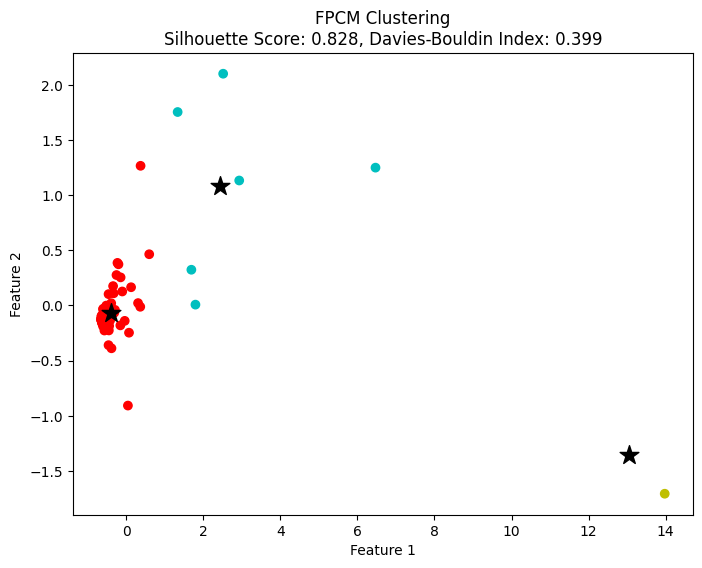

In [32]:
# Set the number of clusters
k = 3
# Set the fuzziness parameter
m = 2
# Set the maximum number of iterations
max_iter = 100
# Set the convergence threshold
tol = 0.0001

clusters, sil_score, db_index = fpcm(X_pca, k, m, tol, max_iter)

In [33]:
silhouette_fpcm = silhouette_score(X_pca, clusters)

In [34]:
print("Silhouette score untuk FPCM: ", silhouette_fpcm)

Silhouette score untuk FPCM:  0.8276270019576544


In [35]:
#Add the cluster labels to the original dataset
df['Hasil Cluster FPCM'] = clusters

df

,hydro_and_marine,solar,wind,bioenergy,Hasil Cluster FPCM
0,29685,1346,9412,2607,0
1,14764,21033,20396,3351,0
2,41998,2043,6792,4591,0
3,777,389,5,4,0
4,399,176,194,578,0
...,...,...,...,...,...
73,4094,462,5476,2701,0
74,5000,0,16,0,0
75,64501,8,88,0,0
76,73496,1660,1803,322,0


In [37]:
import pandas as pd
df = pd.DataFrame(df)

# Save the DataFrame to an Excel file
df.to_excel('output.xlsx', index=False)

FPCM MANUAL FOR HYDRO


In [38]:
import pandas as pd
df = pd.read_excel('renewable electricity generation.xlsx')
df = df[["hydro_and_marine"]]
df

,hydro_and_marine
0,29685
1,14764
2,41998
3,777
4,399
...,...
73,4094
74,5000
75,64501
76,73496


In [49]:
import numpy as np
import pandas as pd

def normalisasi(array_matriks):
    hasil = array_matriks / sum(array_matriks)
    return hasil


def fcm(dataframe, jumlah_cluster = 3, w = 2, maxIter = 100, error_threshold = 0.01):
    jumlah_data, jumlah_fitur = dataframe.shape

    matriks_myu = np.absolute(np.random.randn(jumlah_data, jumlah_fitur))
    v = np.zeros((jumlah_cluster, jumlah_fitur))

    # for (indeks_baris, isi_matriks) in enumerate(matriks_myu):
    #     matriks_myu[indeks_baris] = normalisasi(isi_matriks)

    # df_myu = dataframe # pd.read_excel("renewable_electricity_generation_model.xlsx")
    df = pd.read_excel('hydro_model.xlsx')
    df_myu = df
    jumlah_baris_myu, jumlah_kolom_myu = df_myu.shape
    for index_baris in range(jumlah_baris_myu):
        for index_kolom in range(jumlah_kolom_myu):
            matriks_myu[index_baris][index_kolom] = df_myu.iloc[index_baris][index_kolom]

    jumlah_fungsi_objektif_sebelumnya = 0

    lebih_error = True
    iter_sekarang = 1

    while lebih_error and iter_sekarang <= maxIter:
        d_kuadrat = np.zeros((jumlah_data, jumlah_fitur))
        matriks_myu_baru = np.zeros((jumlah_data, jumlah_cluster))
        gabungan_myu_kuadrat = pow(matriks_myu, 2)

        # cari pusat cluster
        for indeks_cluster in range(jumlah_cluster):
            myu_kuadrat = []
            for indeks_data in range(jumlah_data):
                myu_kuadrat.append(
                    pow(matriks_myu[indeks_data][indeks_cluster], w))
            jumlah_myu_kuadrat = sum(myu_kuadrat)
            for indeks_fitur in range(jumlah_fitur):
                jumlah_myukuadrat_kalifitur = 0
                for indeks_data in range(jumlah_data):
                    jumlah_myukuadrat_kalifitur += myu_kuadrat[indeks_data] * \
                        dataframe.iloc[indeks_data][indeks_fitur]
                v[indeks_cluster][indeks_fitur] = jumlah_myukuadrat_kalifitur / \
                    jumlah_myu_kuadrat

        #print(v)

        # cari myu baru  
        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                for indeks_fitur in range(jumlah_fitur):
                    d_kuadrat[indeks_data][indeks_cluster] += pow(
                        dataframe.iloc[indeks_data][indeks_fitur] - v[indeks_cluster][indeks_fitur], 2)

        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                jumlah_d_kuadrat_i_bagi_d_kuadrat_j = 0
                for j in range (jumlah_cluster):
                    jumlah_d_kuadrat_i_bagi_d_kuadrat_j += pow(
                        d_kuadrat[indeks_data][indeks_cluster] / d_kuadrat[indeks_data][j], 1 / (w - 1))
                matriks_myu_baru[indeks_data][indeks_cluster] = 1 / jumlah_d_kuadrat_i_bagi_d_kuadrat_j
        
        # cari fungsi objektif
        jumlah_fungsi_objektif = 0
        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                    jumlah_fungsi_objektif += d_kuadrat[indeks_data][indeks_cluster] * gabungan_myu_kuadrat[indeks_data][indeks_cluster]
        
        #print(jumlah_fungsi_objektif)
        #print(matriks_myu_baru)
        error = abs(jumlah_fungsi_objektif - jumlah_fungsi_objektif_sebelumnya)
        print('Iterasi ke {}, Hasil Fungsi Objektif = {}, Error = {}'.format(iter_sekarang, jumlah_fungsi_objektif, error))
        
        iter_sekarang += 1
        
        lebih_error = error > error_threshold
        matriks_myu = matriks_myu_baru
        jumlah_fungsi_objektif_sebelumnya = jumlah_fungsi_objektif
        
    print("Hasil akhir matriks FCM yang akan digunakan pada perhitungan FPCM")
    print(matriks_myu)
    return(matriks_myu, v)


def fpcm(dataframe, myu, v, jumlah_cluster = 3, w = 2, eta = 2, maxIter = 100, error_threshold = 0.01):
    jumlah_data, jumlah_fitur = dataframe.shape
    jumlah_fungsi_objektif_sebelumnya = 0
    matriks_t = np.zeros((jumlah_data, jumlah_cluster))
    d_kuadrat_lama = np.zeros((jumlah_data, jumlah_fitur))
    lebih_error = True
    iter_sekarang = 1

    #cari t baru dari myu fcm dan v fcm
    for indeks_data in range(jumlah_data):
        for indeks_cluster in range(jumlah_cluster):
            for indeks_fitur in range(jumlah_fitur):
                d_kuadrat_lama[indeks_data][indeks_cluster] += pow(
                    dataframe.iloc[indeks_data][indeks_fitur] - v[indeks_cluster][indeks_fitur], 2)
            d_kuadrat_lama[indeks_data][indeks_cluster] = 1 / d_kuadrat_lama[indeks_data][indeks_cluster]

    jumlah_t_cluster = []
    for indeks_cluster in range(jumlah_cluster):
        jumlah = 0
        for indeks_data in range(jumlah_data):
            jumlah += d_kuadrat_lama[indeks_data][indeks_cluster]
        jumlah_t_cluster.append(jumlah)
        for indeks_data in range(jumlah_data):
            matriks_t[indeks_data][indeks_cluster] = pow(d_kuadrat_lama[indeks_data][indeks_cluster] / jumlah_t_cluster[indeks_cluster], 1 / (eta - 1))

    while lebih_error and iter_sekarang <= maxIter:
        d_kuadrat_miu = np.zeros((jumlah_data, jumlah_fitur))
        d_kuadrat_t = np.zeros((jumlah_data, jumlah_fitur))
        matriks_myu_baru = np.zeros((jumlah_data, jumlah_cluster))
        matriks_t_baru = np.zeros((jumlah_data, jumlah_cluster))
        gabungan_myu_kuadrat = pow(myu, 2)
        gabungan_t_kuadrat = pow(matriks_t, 2)

        #cari pusat cluster (v)
        for indeks_cluster in range(jumlah_cluster):
            myu_kuadrat = []
            t_kuadrat = []
            for indeks_data in range(jumlah_data):
                myu_kuadrat.append(
                    pow(myu[indeks_data][indeks_cluster], w))
                t_kuadrat.append(
                    pow(matriks_t[indeks_data][indeks_cluster], eta)
                )
            jumlah_myu_t_kuadrat = sum(myu_kuadrat) + sum(t_kuadrat)
            for indeks_fitur in range(jumlah_fitur):
                jumlah_myukuadrat_kalifitur = 0
                for indeks_data in range(jumlah_data):
                    jumlah_myukuadrat_kalifitur += (myu_kuadrat[indeks_data] + t_kuadrat[indeks_data]) * \
                        dataframe.iloc[indeks_data][indeks_fitur]
                v[indeks_cluster][indeks_fitur] = jumlah_myukuadrat_kalifitur / \
                    jumlah_myu_t_kuadrat
        # print(v)

        #cari miu baru
        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                for indeks_fitur in range(jumlah_fitur):
                    d_kuadrat_miu[indeks_data][indeks_cluster] += pow(
                        dataframe.iloc[indeks_data][indeks_fitur] - v[indeks_cluster][indeks_fitur], 2)

        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                jumlah_d_kuadrat_i_bagi_d_kuadrat_j = 0
                for j in range (jumlah_cluster):
                    jumlah_d_kuadrat_i_bagi_d_kuadrat_j += pow(
                        d_kuadrat_miu[indeks_data][indeks_cluster] / d_kuadrat_miu[indeks_data][j], 1 / (w - 1))
                matriks_myu_baru[indeks_data][indeks_cluster] = 1 / jumlah_d_kuadrat_i_bagi_d_kuadrat_j

        #cari t baru
        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                for indeks_fitur in range(jumlah_fitur):
                    d_kuadrat_t[indeks_data][indeks_cluster] += pow(
                        dataframe.iloc[indeks_data][indeks_fitur] - v[indeks_cluster][indeks_fitur], 2)
                d_kuadrat_t[indeks_data][indeks_cluster] = 1 / d_kuadrat_t[indeks_data][indeks_cluster]

        jumlah_t_cluster = []
        for indeks_cluster in range(jumlah_cluster):
            jumlah = 0
            for indeks_data in range(jumlah_data):
                jumlah += d_kuadrat_t[indeks_data][indeks_cluster]
            jumlah_t_cluster.append(jumlah)
            for indeks_data in range(jumlah_data):
                matriks_t_baru[indeks_data][indeks_cluster] = pow(d_kuadrat_t[indeks_data][indeks_cluster] / jumlah_t_cluster[indeks_cluster], 1 / (eta - 1))

        # cari fungsi objektif
        jumlah_fungsi_objektif = 0
        for indeks_data in range(jumlah_data):
            for indeks_cluster in range(jumlah_cluster):
                jumlah_fungsi_objektif += d_kuadrat_miu[indeks_data][indeks_cluster] *(gabungan_myu_kuadrat[indeks_data][indeks_cluster] + gabungan_t_kuadrat[indeks_data][indeks_cluster])
        error = abs(jumlah_fungsi_objektif - jumlah_fungsi_objektif_sebelumnya)
        print('Iterasi ke {}, Hasil Fungsi Objektif = {}, Error = {}'.format(iter_sekarang, jumlah_fungsi_objektif, error))
        
        iter_sekarang += 1
        # lebih_error = abs(jumlah_fungsi_objektif - jumlah_fungsi_objektif_sebelumnya)
        lebih_error = error > error_threshold
        myu = matriks_myu_baru
        matriks_t = matriks_t_baru
        jumlah_fungsi_objektif_sebelumnya = jumlah_fungsi_objektif


    print(myu)
    print("Hasil Klusterisasi \n c1 c2 c3")
    for matriks_baris in myu:
        hasil_maksimal = max(matriks_baris)
        for x in matriks_baris:
            print(" v  " if x == hasil_maksimal else "   ", end="")
        print()
path = "hydro_model.xlsx"
# df = pd.read_excel(path)
# 
import pandas as pd
df = pd.read_excel('hydro_model.xlsx')
# df = df[["hydro_and_marine", 'solar']]
# (myu_fcm, v_fcm) = fcm(df)
fpcm(df, myu_fcm, v_fcm)

Iterasi ke 1, Hasil Fungsi Objektif = 149494070649.70935, Error = 149494070649.70935
Iterasi ke 2, Hasil Fungsi Objektif = 149488231526.4343, Error = 5839123.275054932
Iterasi ke 3, Hasil Fungsi Objektif = 149485442612.60065, Error = 2788913.8336486816
Iterasi ke 4, Hasil Fungsi Objektif = 149483999366.23404, Error = 1443246.366607666
Iterasi ke 5, Hasil Fungsi Objektif = 149483246759.21475, Error = 752607.0192871094
Iterasi ke 6, Hasil Fungsi Objektif = 149482853111.99222, Error = 393647.2225341797
Iterasi ke 7, Hasil Fungsi Objektif = 149482646915.29297, Error = 206196.69924926758
Iterasi ke 8, Hasil Fungsi Objektif = 149482538814.1709, Error = 108101.1220703125
Iterasi ke 9, Hasil Fungsi Objektif = 149482482108.4416, Error = 56705.72930908203
Iterasi ke 10, Hasil Fungsi Objektif = 149482452350.8378, Error = 29757.603790283203
Iterasi ke 11, Hasil Fungsi Objektif = 149482436730.37103, Error = 15620.466766357422
Iterasi ke 12, Hasil Fungsi Objektif = 149482428529.11447, Error = 8201.2

In [53]:
df = pd.read_excel('renewable_electricity_generation_model.xlsx')

In [54]:
df

,hydro_and_marine,solar,wind,bioenergy
0,29685,1346,9412,2607
1,14764,21033,20396,3351
2,41998,2043,6792,4591
3,777,389,5,4
4,399,176,194,578
...,...,...,...,...
73,4094,462,5476,2701
74,5000,0,16,0
75,64501,8,88,0
76,73496,1660,1803,322


In [55]:
import numpy as np
import pandas as pd
import ydata_profiling as pp
from pycaret.regression import *
from sklearn.model_selection import train_test_split

In [56]:
profile = pp.ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]